## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from wisps import datasets

In [3]:
spex=datasets['spex']
trash=pd.read_pickle(wisps.OUTPUT_FILES+'/trash.pkl')
trash['label']=0.

In [4]:
man=(datasets['manjavacas']).rename(columns={'f':'f_test'})
schn=(datasets['schneider']).rename(columns={'f':'f_test'})

In [5]:
sf0=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [6]:
sf=pd.DataFrame.from_records(pd.DataFrame(sf0).values.flatten())

In [7]:
sf['spt']=sf['spt_new']

In [8]:
spex['spt']=spex.spt.apply(wisps.make_spt_number)
man['spt']=man.spt.apply(wisps.make_spt_number)
schn['spt']=schn.spt.apply(wisps.make_spt_number)
trash['spt']=trash.spt.apply(wisps.make_spt_number)
sf['spt']=sf.spt.apply(wisps.make_spt_number)
spex['name']=spex['grism_id']

In [9]:
cand_ids=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')
cand_ids['grism_id']=cand_ids.spectra.apply(lambda x: x.grism_id.lower())

In [10]:
stars=wisps.datasets['stars']
cands=(stars[stars.grism_id.isin(cand_ids.grism_id)]).reset_index(drop=True)

In [11]:
cands['label']=1
cands['spt']=cands.spt.apply(wisps.make_spt_number)

In [12]:
features =np.concatenate([wisps.INDEX_NAMES, ['spex_chi', 'snr2',
       'line_chi', 'label', 'f_test', 'spt', 'snr1']])

In [13]:
from scipy import stats

In [14]:
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)

man['x']=man.spex_chi/man.line_chi
schn['x']=schn.spex_chi/schn.line_chi
man['f_test']=man.x.apply(f_test_comp)
schn['f_test']=schn.x.apply(f_test_comp)
spex['f_test']=(spex.spex_chi/spex.line_chi).apply(f_test_comp)
sf['f_test']=(sf.spex_chi/sf.line_chi).apply(f_test_comp)

In [15]:
sf.columns

Index(['snr1', 'snr2', 'snr3', 'snr4', 'H_2O-1/J-Cont', 'H_2O-2/H_2O-1',
       'H-cont/H_2O-1', 'CH_4/H_2O-1', 'H_2O-2/J-Cont', 'H-cont/J-Cont',
       'CH_4/J-Cont', 'H-cont/H_2O-2', 'CH_4/H_2O-2', 'CH_4/H-Cont',
       'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont',
       'H_2O-2+CH_4/J-Cont', 'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont',
       'f_test', 'line_chi', 'spex_chi', 'spt_new', 'sp_old', 'spt'],
      dtype='object')

In [16]:
trash['name']=trash.grism_id
sf['name']=['spc {}'+str(i) for i in sf.index]

In [17]:
feats=[x for x in features if x not in ['name']]

In [18]:
def add_binary_label(row):
    label=0.
    if (row.spt >17 and row.snr2 >3.):
        label=1.
    return label

In [19]:
trash['label']=0.
spex['label']=spex.apply(add_binary_label, axis=1)
schn['label']=schn.apply(add_binary_label, axis=1)
sf['label']=schn.apply(add_binary_label, axis=1)

In [20]:
training_set=wisps.Annotator.reformat_table(pd.concat( [trash[features], spex[features],
                                                        schn[features]]))

In [21]:
training_set=(training_set[feats]).dropna(how='all').reset_index(drop=True)

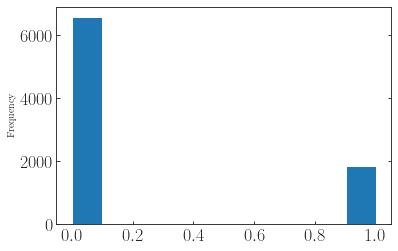

In [22]:
training_set.label.plot(kind='hist')

In [23]:
label0=(training_set[training_set.label==0]).reset_index(drop=True)
label1=(training_set[training_set.label==1]).reset_index(drop=True)

In [24]:
final_set=pd.concat([label0, label1]).reset_index(drop=True)

In [25]:
len(trash[trash.snr1>3.]), len(spex[spex.snr1>3]), len(schn[schn.snr1>3.]), len(label0), len(label1)

(4477, 2581, 19, 6574, 1845)

In [26]:
final_set[feats]=final_set[feats].applymap(float)
final_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl')

In [27]:
len(final_set)

8419

In [28]:
final_set.columns

Index(['H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'H_2O-1+H_2O-2/J-Cont',
       'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont',
       'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont', 'spex_chi', 'snr2',
       'line_chi', 'label', 'f_test', 'spt', 'snr1'],
      dtype='object')